## NPS and Wait Time Pulled from 2024

In [4]:
!pip install statsmodels
import statsmodels.api as sm
print("Statsmodels installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 50.7 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Statsmodels installed successfully!


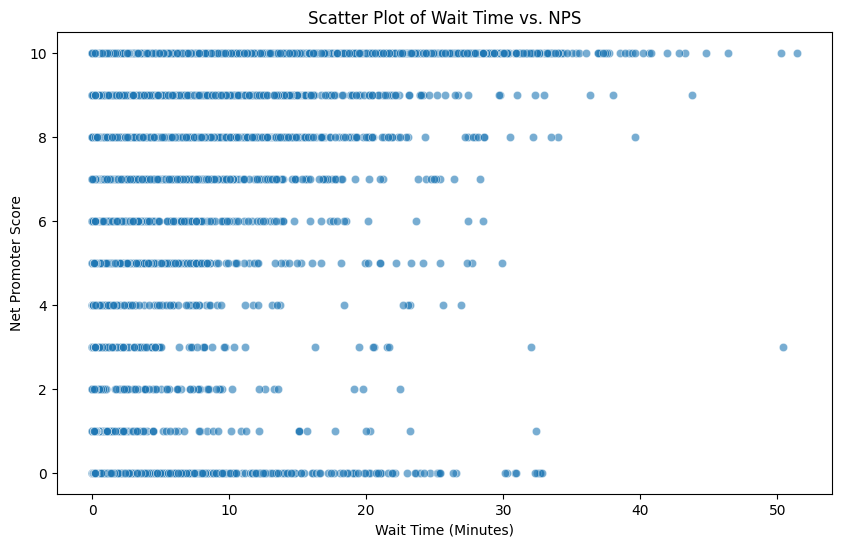

Spearman's Rank Correlation: -0.02


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


ValueError: Found array with dim 3. PolynomialFeatures expected <= 2.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures  # Correct import
from scipy.optimize import fsolve
from scipy.stats import spearmanr  # Import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('AWT vs. NPS v2.csv')  # Replace with your actual file path

# Normalize WAIT_TIME to minutes if it's in seconds
data['WAIT_TIME_MINUTES'] = data['WAIT_TIME'] / 60

# Transform NPS to reduce skewness (optional: log transformation or grouping NPS into Detractors, Passives, Promoters)
data['NPS_GROUP'] = pd.cut(data['NET_PROMOTER_SCORE'], bins=[-np.inf, 6, 8, np.inf], labels=['Detractor', 'Passive', 'Promoter'])

# 1. Visualize the relationship between Wait Time and NPS
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAIT_TIME_MINUTES', y='NET_PROMOTER_SCORE', data=data, alpha=0.6)
plt.title('Scatter Plot of Wait Time vs. NPS')
plt.xlabel('Wait Time (Minutes)')
plt.ylabel('Net Promoter Score')
plt.show()

# 2. Spearman’s Rank Correlation to check the relationship between Wait Time and NPS
corr, _ = spearmanr(data['WAIT_TIME_MINUTES'], data['NET_PROMOTER_SCORE'])
print(f"Spearman's Rank Correlation: {corr:.2f}")

# 3. Fit Linear Regression Model
X = data[['WAIT_TIME_MINUTES']]
y = data['NET_PROMOTER_SCORE']
linear_model = LinearRegression()
linear_model.fit(X, y)

# 4. Polynomial Regression Model (degree=2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data[['WAIT_TIME_MINUTES']])
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# 5. Find the tipping point where NPS drops below 80 using fsolve
def tipping_point_poly(poly_model, poly, target=80):
    def equation(x):
        transformed_input = poly.transform([[x]])  # Transform input
        return poly_model.predict(transformed_input)[0] - target  # NPS = 80
    
    tipping_point = fsolve(equation, 5)  # Initial guess: 5 minutes
    return tipping_point[0]

tipping_point_poly_value = tipping_point_poly(poly_model, poly)
print(f"Tipping Point (Polynomial Regression): {tipping_point_poly_value:.2f} minutes")

# 6. Plotting Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAIT_TIME_MINUTES', y='NET_PROMOTER_SCORE', data=data, color='blue', label='Data Points')

# Plot Linear Regression
plt.plot(data['WAIT_TIME_MINUTES'], linear_model.predict(X), color='red', label='Linear Regression')

# Plot Polynomial Regression
X_range = np.linspace(min(data['WAIT_TIME_MINUTES']), max(data['WAIT_TIME_MINUTES']), 100).reshape(-1, 1)
plt.plot(X_range, poly_model.predict(poly.transform(X_range)), color='green', label='Polynomial Regression')

# Add Tipping Point Line
plt.axvline(x=tipping_point_poly_value, color='purple', linestyle='--', label=f'Tipping Point: {tipping_point_poly_value:.2f} min')

plt.title('Wait Time vs NPS with Tipping Point', fontsize=16)
plt.xlabel('Wait Time (Minutes)', fontsize=12)
plt.ylabel('Net Promoter Score', fontsize=12)
plt.legend()
plt.show()
